In [3]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from lib import cluster_jzar, climb_jor

In [4]:
pd.set_option("display.max_columns",None)
pd.set_option('display.max_rows', 10)

### We have 3 types of data:
- `Independent features (clustered)` => <b>In this notebook we will work on this one
- How good the route is (the higher the better)
- Grade, Location, sex, heigh (defined by user)


# Clustering Routes

First we retrieve the features dataframe

In [6]:
routes_features = pd.read_csv('../data/routes_features.csv',low_memory=False, index_col=0)

In [6]:
print(routes_features.shape)
routes_features.tail(5)

(55858, 19)


,name_id,country,crag,sector,name,ascents_count,repeat_sum,recommend_sum,chiped_sum,soft_sum,hard_sum,traditional_sum,tall_recommend_sum,grade_mean,sentiment_mean,rating_mean,sex_ratio,yellow_id_mean,first_ascent_mean
55853,55853,zaf,van stadens,cleopatra wall,steel sunday,3,0.0,2.0,1.0,0,0,0,0,40.0,0.4753,NaN,0.0,255.0,0.0
55854,55854,zaf,van stadens,cleopatra wall,suck it up princess,2,0.0,0.0,0.0,0,0,0,0,44.0,0.7074,NaN,0.0,127.5,0.0
55855,55855,zaf,van stadens,cleopatra wall,sunset sonata,2,0.0,0.0,0.0,1,0,0,1,54.5,0.8636,3.0,0.0,255.0,0.5
55856,55856,zaf,van stadens,cleopatra wall,tekel,2,0.0,1.0,0.0,0,0,0,0,44.0,NaN,2.0,0.0,0.0,0.0
55857,55857,zaf,waterval boven,baboon buttress,pretenders,2,0.0,1.0,0.0,0,0,0,0,49.0,0.8020,NaN,0.0,255.0,0.0


## Prepare the dataframe for clustering

In [61]:
# Drop not interesting features
X = routes_features[['ascents_count','repeat_sum','chiped_sum','soft_sum','hard_sum','traditional_sum','tall_recommend_sum','sex_ratio','first_ascent_mean']]
X.head()

,ascents_count,repeat_sum,chiped_sum,soft_sum,hard_sum,traditional_sum,tall_recommend_sum,sex_ratio,first_ascent_mean
0,4,0.0,0.0,0,1,0,-1,0.0,0.0
1,6,0.0,0.0,1,1,0,-1,0.0,0.0
2,5,0.0,0.0,0,0,0,0,0.0,0.0
3,3,0.0,0.0,0,1,0,0,0.0,0.0
4,2,0.0,0.0,1,0,0,1,0.0,0.0


Transform sum to rates

In [64]:
X_new = X.copy()
X_new['repeat_rate'] = X_new.repeat_sum/X.ascents_count
X_new['chiped_rate'] = X_new.chiped_sum/X.ascents_count
X_new['soft_rate'] = X_new.soft_sum/X.ascents_count
X_new['hard_rate'] = X_new.hard_sum/X.ascents_count
X_new['traditional_rate'] = X_new.traditional_sum/X.ascents_count
X_new['tall_recommend_rate'] = X_new.tall_recommend_sum/X.ascents_count
X = X_new[['ascents_count','repeat_rate','chiped_rate','soft_rate','hard_rate','traditional_rate','tall_recommend_rate','sex_ratio','first_ascent_mean']]
X.head()

,ascents_count,repeat_rate,chiped_rate,soft_rate,hard_rate,traditional_rate,tall_recommend_rate,sex_ratio,first_ascent_mean
0,4,0.0,0.0,0.000000,0.250000,0.0,-0.250000,0.0,0.0
1,6,0.0,0.0,0.166667,0.166667,0.0,-0.166667,0.0,0.0
2,5,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
3,3,0.0,0.0,0.000000,0.333333,0.0,0.000000,0.0,0.0
4,2,0.0,0.0,0.500000,0.000000,0.0,0.500000,0.0,0.0


In [65]:
X.corr()

,ascents_count,repeat_rate,chiped_rate,soft_rate,hard_rate,traditional_rate,tall_recommend_rate,sex_ratio,first_ascent_mean
ascents_count,1.000000,-0.011173,-0.021113,0.007422,-0.047636,-0.039778,0.005870,0.044584,-0.058248
repeat_rate,-0.011173,1.000000,-0.012113,-0.005719,-0.001229,0.037641,0.006325,-0.025627,0.025907
chiped_rate,-0.021113,-0.012113,1.000000,0.039773,0.011554,-0.016925,-0.005703,-0.037049,0.038292
soft_rate,0.007422,-0.005719,0.039773,1.000000,-0.139273,-0.044010,0.046628,-0.063966,0.027025
hard_rate,-0.047636,-0.001229,0.011554,-0.139273,1.000000,-0.002058,-0.048318,-0.060214,0.009883
traditional_rate,-0.039778,0.037641,-0.016925,-0.044010,-0.002058,1.000000,-0.006288,-0.005910,-0.012846
tall_recommend_rate,0.005870,0.006325,-0.005703,0.046628,-0.048318,-0.006288,1.000000,0.014150,0.004899
sex_ratio,0.044584,-0.025627,-0.037049,-0.063966,-0.060214,-0.005910,0.014150,1.000000,-0.049881
first_ascent_mean,-0.058248,0.025907,0.038292,0.027025,0.009883,-0.012846,0.004899,-0.049881,1.000000


<AxesSubplot:>

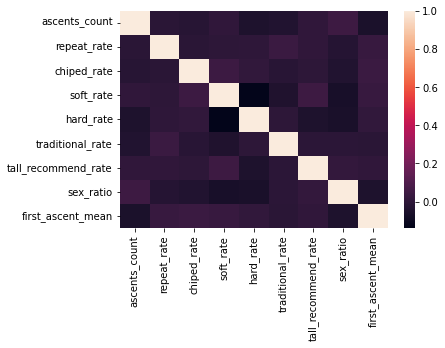

In [66]:
sns.heatmap(X.corr())

Not a big correlation between features

In [69]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
filename = "../transformer/scaler.pickle" # Path with filename
with open(filename, "wb") as file:
        pickle.dump(scaler,file)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
print(X_scaled_df.shape)
display(X_scaled_df.head(3))

(55858, 9)


,ascents_count,repeat_rate,chiped_rate,soft_rate,hard_rate,traditional_rate,tall_recommend_rate,sex_ratio,first_ascent_mean
0,-0.326844,-0.213352,-0.108895,-0.506343,1.125318,-0.158027,-1.761691,-0.611235,-0.198984
1,-0.237211,-0.213352,-0.108895,0.578574,0.584765,-0.158027,-1.175380,-0.611235,-0.198984
2,-0.282028,-0.213352,-0.108895,-0.506343,-0.496339,-0.158027,-0.002757,-0.611235,-0.198984


### Check the PCA

In [70]:
pca = PCA(n_components=None)
principalComponents = pca.fit_transform(X_scaled_df)
principalDf = pd.DataFrame(data = principalComponents)
pca.explained_variance_ratio_

array([0.13180752, 0.12862985, 0.11703265, 0.10941848, 0.10868076,
       0.10672275, 0.10620676, 0.10147798, 0.09002325])

All pcas have more or less the same variance ratio

# Clustering model - K-Means

In [71]:
K = range(2, 21)
inertia = []
silhouette = []

for k in K:
    print("Training a K-Means model with {} neighbours! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_scaled_df)
    filename = "../model/kmeans_" + str(k) + ".pickle" # Path with filename
    with open(filename, "wb") as file:
        pickle.dump(kmeans,file)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))

Training a K-Means model with 2 neighbours! 

Training a K-Means model with 3 neighbours! 

Training a K-Means model with 4 neighbours! 

Training a K-Means model with 5 neighbours! 

Training a K-Means model with 6 neighbours! 

Training a K-Means model with 7 neighbours! 

Training a K-Means model with 8 neighbours! 

Training a K-Means model with 9 neighbours! 

Training a K-Means model with 10 neighbours! 

Training a K-Means model with 11 neighbours! 

Training a K-Means model with 12 neighbours! 

Training a K-Means model with 13 neighbours! 

Training a K-Means model with 14 neighbours! 

Training a K-Means model with 15 neighbours! 

Training a K-Means model with 16 neighbours! 

Training a K-Means model with 17 neighbours! 

Training a K-Means model with 18 neighbours! 

Training a K-Means model with 19 neighbours! 

Training a K-Means model with 20 neighbours! 



I will 3D plot in 2 groups


Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

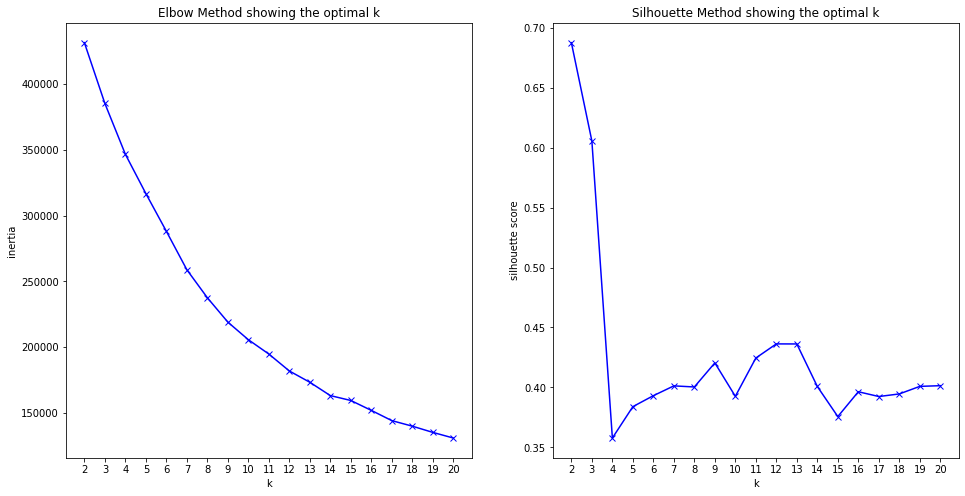

In [37]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(K, inertia, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia')
ax[0].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[0].set_title('Elbow Method showing the optimal k')
ax[1].plot(K, silhouette, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette score')
ax[1].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[1].set_title('Silhouette Method showing the optimal k')

We will take 6

In [73]:
k = 9
filename = "../model/kmeans_" + str(k) + ".pickle" # Path with filename
with open(filename, "rb") as file:
    kmeans = pickle.load(file)
clusters = kmeans.predict(X_scaled_df)
#clusters
pd.Series(clusters).value_counts().sort_index() # Number of songs in each cluster

0     6561
1     7048
2    30500
3     5601
4     1333
5      506
6     1176
7     1354
8     1779
dtype: int64

In [74]:
clusters

array([3, 2, 2, ..., 7, 2, 2], dtype=int32)

#### Find the centroids

In [76]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
pd.DataFrame(scaler.inverse_transform(centroids), columns = X.columns)

,ascents_count,repeat_rate,chiped_rate,soft_rate,hard_rate,traditional_rate,tall_recommend_rate,sex_ratio,first_ascent_mean
0,6.451303,0.004422,1.522094e-03,0.412846,0.023076,0.001589,0.022216,0.066835,0.004079
1,6.606925,0.004441,3.183036e-04,0.019408,0.049282,0.001691,0.014918,0.399231,0.002944
2,10.035569,0.005642,1.183196e-03,0.031354,0.031472,0.002027,0.002015,0.044014,0.004055
3,5.107659,0.003352,7.745633e-04,0.014545,0.426598,0.002939,-0.053599,0.034000,0.003000
4,5.552888,0.419707,5.312340e-04,0.064521,0.074348,0.013215,0.003697,0.064177,0.019161
5,4.509881,0.004832,3.838689e-01,0.132314,0.087135,0.000395,-0.004966,0.038027,0.046364
6,5.137755,0.025156,-1.734723e-18,0.030327,0.069355,0.811276,-0.002322,0.088107,0.003540
7,2.800591,0.005805,3.528639e-04,0.093299,0.086938,0.006656,0.003002,0.043179,0.423063
8,105.665541,0.010446,1.185369e-03,0.082567,0.047037,0.001384,0.003380,0.118824,0.001807


Clusters more or less explanation
- 0 - Soft routes
- 1 - Routes for some reason preferred by women
- 2 - Famouse routes 
- 3 - Very hard routes
- 4 - Very repeated routes
- 5 - Chipped routes, with soft rate
- 6 - Traditiona, not chipped routes
- 7 - Easy to On-sight routes, not very repeated
- 8 - Very famouse routes but not so repeated and not so traditional

### Check the PCA

In [77]:
pca = PCA(n_components=None)
principalComponents = pca.fit_transform(X_scaled_df)
principalDf = pd.DataFrame(data = principalComponents)
pca.explained_variance_ratio_

array([0.13180752, 0.12862985, 0.11703265, 0.10941848, 0.10868076,
       0.10672275, 0.10620676, 0.10147798, 0.09002325])

Just for fun I will 3D plot but we have 8 groups... impossible to visualize with the limited human brain..

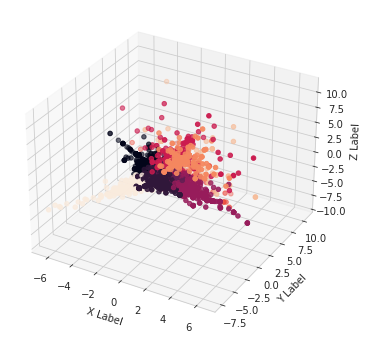

In [79]:
from lib.plot_jzar import *
# %matplotlib notebook
plot3D(x = principalDf[0],y = principalDf[1],z = principalDf[2],color = clusters, fraction = 0.2)

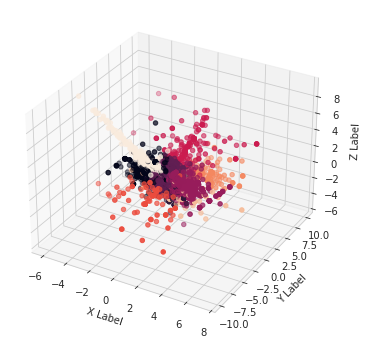

In [80]:
# %matplotlib notebook
plot3D(x = principalDf[0],y = principalDf[2],z = principalDf[3],color = clusters, fraction = 0.2)

And we see that the assigned clusters are not so bad

### Assing each route to a cluster

In [81]:
X_cl = routes_features.copy()
X_cl["cluster"] = pd.Series(clusters)

In [82]:
routes_clustered = X_cl.drop(columns = ['chiped_sum','soft_sum','hard_sum','traditional_sum','sex_ratio'])
print(routes_clustered.shape)
routes_clustered.head()

(55858, 15)


,name_id,country,crag,sector,name,ascents_count,repeat_sum,recommend_sum,tall_recommend_sum,grade_mean,sentiment_mean,rating_mean,yellow_id_mean,first_ascent_mean,cluster
0,0,and,montserrat,prohibitivo,diagonal de la x,4,0.0,0.0,-1,49.250000,0.0000,2.00,0.0,0.0,3
1,1,and,montserrat,prohibitivo,mehir,6,0.0,1.0,-1,49.000000,0.0000,2.00,0.0,0.0,2
2,2,and,montserrat,prohibitivo,pas de la discordia,5,0.0,1.0,0,49.000000,0.0000,1.75,0.0,0.0,2
3,3,and,tartareu,bombo suis,tenedor libre,3,0.0,1.0,0,44.333333,0.0000,3.00,0.0,0.0,3
4,4,arg,bandurrias,rincon,tendinitis,2,0.0,0.0,1,48.500000,0.0762,1.00,0.0,0.0,0


In [83]:
clust_0 = routes_clustered[routes_clustered.cluster == 0]

In [84]:
routes_clustered.cluster.value_counts()

2    30500
1     7048
0     6561
3     5601
8     1779
7     1354
4     1333
6     1176
5      506
Name: cluster, dtype: int64

In [85]:
routes_clustered.to_csv('../data/routes_clustered.csv')